In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import statistics
import matplotlib.pyplot as plt

# Load feature table

In [4]:
df = pd.read_csv('./data/16_over_feature_with_label_all_48H.csv')

In [3]:
df.shape

(224951, 338)

# Use admissions and patient tables to filter patient population

In [5]:
admissions_df = pd.read_csv('./data/admissions.csv')
admissions_df['HOSPITAL_EXPIRE_FLAG'].value_counts()

0    53122
1     5854
Name: HOSPITAL_EXPIRE_FLAG, dtype: int64

In [6]:
admissions_df['ADMITTIME'] = pd.to_datetime(admissions_df['ADMITTIME'])
admissions_df['DISCHTIME'] = pd.to_datetime(admissions_df['DISCHTIME'])
admissions_df['length_of_stay'] = (admissions_df['DISCHTIME'] - admissions_df['ADMITTIME']) / np.timedelta64(1, 'h')
admissions_df.dtypes

index                            int64
ROW_ID                           int64
SUBJECT_ID                       int64
HADM_ID                          int64
ADMITTIME               datetime64[ns]
DISCHTIME               datetime64[ns]
DEATHTIME                       object
ADMISSION_TYPE                  object
ADMISSION_LOCATION              object
DISCHARGE_LOCATION              object
INSURANCE                       object
LANGUAGE                        object
RELIGION                        object
MARITAL_STATUS                  object
ETHNICITY                       object
EDREGTIME                       object
EDOUTTIME                       object
DIAGNOSIS                       object
HOSPITAL_EXPIRE_FLAG             int64
HAS_CHARTEVENTS_DATA             int64
length_of_stay                 float64
dtype: object

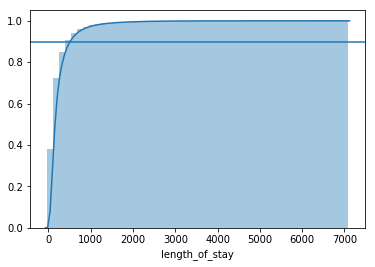

In [7]:
g = sns.distplot(admissions_df['length_of_stay'],
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))
ax = g.axes
ax.axhline(.9)
plt.show()

### Filter out stays less than 4 hours or longer than 21 days AND patient is alive

In [8]:
time_too_short = ((admissions_df['length_of_stay'] > 24 * 21) & (admissions_df['HOSPITAL_EXPIRE_FLAG'] == 0)) | (admissions_df['length_of_stay'] < 4)

In [9]:
admissions_filtered_time = admissions_df[~time_too_short]

In [10]:
df_filtered_time = df[df['HADM_ID'].isin(admissions_filtered_time['HADM_ID'])]
admissions_filtered = admissions_df[admissions_df['HADM_ID'].isin(df_filtered_time['HADM_ID'])]
admissions_filtered.to_csv('./data/admissions_final_cohort.csv')
df_filtered_time.drop(columns=['HADM_ID', 'bin_num'], inplace=True)

/Users/chriszhou/anaconda/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [11]:
df_filtered_time.shape

(160110, 336)

In [12]:
admissions_filtered.shape

(41631, 21)

### Remove Ethnicity

In [13]:
df_filtered_time = df_filtered_time.loc[:, ~df_filtered_time.columns.str.startswith('ethnicity')]

In [14]:
df_filtered_time['label'].value_counts()

0    155608
1      4502
Name: label, dtype: int64

### Add range feature from min and max

In [15]:
feature_col=df_filtered_time.columns.values
feature_col_mm=list(filter(lambda k: k.endswith('_max') or k.endswith('_min'), feature_col))
feature_col_mm.sort()
feature_col_mm
for i,k in zip(feature_col_mm[0::2], feature_col_mm[1::2]):
    col_name_new=i.split('_')[0]+"_range"
    df_filtered_time[col_name_new] = df_filtered_time[i]-df_filtered_time[k]

In [16]:
df_filtered_time.dtypes.index.to_list()

['Chloride_max',
 'Creatinine_max',
 'Glucose_max',
 'Hematocrit_max',
 'Hemoglobin_max',
 'Platelets_max',
 'Potassium_max',
 'Red blood cell count_max',
 'Sodium_max',
 'White blood cell count_max',
 'Chloride_min',
 'Creatinine_min',
 'Glucose_min',
 'Hematocrit_min',
 'Hemoglobin_min',
 'Platelets_min',
 'Potassium_min',
 'Red blood cell count_min',
 'Sodium_min',
 'White blood cell count_min',
 'Chloride_mean',
 'Creatinine_mean',
 'Glucose_mean',
 'Hematocrit_mean',
 'Hemoglobin_mean',
 'Platelets_mean',
 'Potassium_mean',
 'Red blood cell count_mean',
 'Sodium_mean',
 'White blood cell count_mean',
 'Diastolic blood pressure_max',
 'Glascow coma scale eye opening_max',
 'Glascow coma scale motor response_max',
 'Glascow coma scale verbal response_max',
 'Heart Rate_max',
 'Mean blood pressure_max',
 'Oxygen saturation_max',
 'Respiratory rate_max',
 'Systolic blood pressure_max',
 'Temperature_max',
 'Diastolic blood pressure_min',
 'Glascow coma scale eye opening_min',
 'Glasco

# We see that the classes are extremely imbalanced. Two ways of dealing with imbalanced data

## 1. downsample majority class

In [266]:
from sklearn.utils import resample
df_majority = df_filtered_time[df_filtered_time.label==0]
df_minority = df_filtered_time[df_filtered_time.label==1]
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=5000,     # to match minority class
                                 random_state=123)
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
label_downsampled = df_downsampled['label'].copy()
df_downsampled.drop(columns=['label'], inplace=True)

In [18]:
df_downsampled.shape

(9502, 314)

# 2. upsample minority class

I noticed that if we upsample before train-test splitting, the same examples will show up one both sides and the model to over fit. So proper way to do this is do train test split before up sampling. Then only upsample the train set.

### Use stratified sampling

In [232]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=.25, random_state=42)
for train_index, test_index in split.split(df_filtered_time, df_filtered_time['label']):
    train_set = df_filtered_time.iloc[train_index, :]
    test_set = df_filtered_time.iloc[test_index, :]
df_majority = train_set[train_set.label==0]
df_minority = train_set[train_set.label==1]
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=100000,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled_train = pd.concat([df_majority, df_minority_upsampled])
label_upsampled_train = df_upsampled_train['label'].copy()
df_upsampled_train.drop(columns=['label'], inplace=True)

label_upsampled_test = test_set['label'].copy()
df_upsampled_test = test_set.drop(columns=['label'])

In [20]:
label_upsampled_train.value_counts()

0    116706
1    100000
Name: label, dtype: int64

In [21]:
label_upsampled_test.value_counts()

0    38902
1     1126
Name: label, dtype: int64

### Original Data

In [22]:
label_og = df_filtered_time['label'].copy()
df_og = df_filtered_time.drop(columns=['label'])

# Now we are ready to screen some hyperparameters
### Define methods for removing certain features

In [19]:
from sklearn.preprocessing import FunctionTransformer
abnormal_cols = df_downsampled.columns[df_downsampled.columns.str.startswith('abnormal')]
abnormal_ix = [
    list(df_downsampled.columns).index(col)
    for col in abnormal_cols]
urine_ix = list(df_downsampled.columns).index('Urine output_sum')
range_cols = df_downsampled.columns[df_downsampled.columns.str.contains('range')]
range_ix = [
    list(df_downsampled.columns).index(col)
    for col in range_cols]
def range_remover(X, remove_range=False):
    if remove_range:
        X = np.delete(X, range_ix, axis=1)
    return X
def urine_remover(X, remove_urine=False):
    if remove_urine:
        X = np.delete(X, urine_ix, axis=1)
    return X
def abnormal_lab_sum(X, sum_abnormal_lab=True):
    if sum_abnormal_lab:
        abnormal_labs = X[:, abnormal_ix]
        sum_abnormal = np.sum(abnormal_labs, axis=1)
        X = np.c_[X, sum_abnormal]
    return X
def remove_abnormal(X, remove_abnormal_lab=False):
    if remove_abnormal_lab:
        X = np.delete(X, abnormal_ix, axis=1)
    return X

In [20]:
from sklearn.base import BaseEstimator, TransformerMixin
class Percent_na_remover(BaseEstimator, TransformerMixin):
    def __init__(self, percent_na=.45):
        self.percent_na = percent_na
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        nanvals = np.isnan(X)
        nans_per_col = np.count_nonzero(nanvals, axis=0)
        ix_to_remove = []
        for ix, num_nans in enumerate(nans_per_col):
            if (num_nans / X.shape[0]) > self.percent_na:
                ix_to_remove.append(ix)
        X = np.delete(X, ix_to_remove, axis=1)
        return X

### Construct pipeline for prepping data

In [241]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
prep_pipeline = Pipeline([
    ('range_remove', FunctionTransformer(range_remover, validate=False,
                                         kw_args={'remove_range': False})),
    ('urine_remove', FunctionTransformer(urine_remover, validate=False, 
                                         kw_args={'remove_urine': False})),
    ('abnormal_sum', FunctionTransformer(abnormal_lab_sum, validate=False, 
                                         kw_args={'sum_abnormal_lab': True})),
    ('remove_abnormal_labs', FunctionTransformer(remove_abnormal, validate=False, 
                                         kw_args={'remove_abnormal_lab': False})),
    ('remove_na_percent', Percent_na_remover(percent_na=.5)),
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scalar', StandardScaler())
])

### To screen hyperparameters, we want one pipeline to feed into gridsearchCV

In [22]:
from sklearn.ensemble import RandomForestClassifier
prep_and_predict = Pipeline([
    ('prep', prep_pipeline),
    ('rnd', RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=1))
])

In [23]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# We need to determine which data set we should use: downsampled, upsampled, or original

### Downsample

In [98]:
split = StratifiedKFold(n_splits=4, random_state=42)
for train_index, test_index in split.split(df_downsampled, label_downsampled):
    X_train = df_downsampled.iloc[train_index, :].values
    X_test = df_downsampled.iloc[test_index, :].values
    y_train = label_downsampled.iloc[train_index].values
    y_test = label_downsampled.iloc[test_index].values

In [99]:
X_train_prepped = prep_pipeline.fit_transform(X_train)
X_test_prepped = prep_pipeline.transform(X_test)

In [100]:
prep_and_predict

Pipeline(memory=None,
     steps=[('prep', Pipeline(memory=None,
     steps=[('range_remove', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function range_remover at 0x1a0e29a620>, inv_kw_args=None,
          inverse_func=None, kw_args={'remove_range': False},
          pass_y='deprecated', vali...stimators=50, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False))])

In [101]:
from sklearn import metrics
prep_and_predict.fit(X_train_prepped,y_train)
y_pred = prep_and_predict.predict_proba(X_test_prepped)[:, 1]
prec_n, rec_n, _ = metrics.precision_recall_curve(y_test, y_pred)

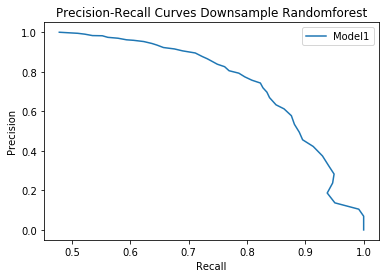

In [103]:
plt.plot(prec_n, rec_n, label = "Model1")
# plt.plot(prec2, rec2, label = "Model2")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves Downsample Randomforest")
plt.legend()
plt.savefig("./fig/precision_recall_curves_downsample_random_forest.png")
plt.show()

### upsample

In [78]:
# # Renaming upsampled data
X_train = df_upsampled_train.values
X_test = df_upsampled_test.values
y_train = label_upsampled_train.values
y_test = label_upsampled_test.values

In [79]:
X_train.shape

(216706, 314)

In [80]:
X_train_prepped = prep_pipeline.fit_transform(X_train)

In [81]:
X_test_prepped = prep_pipeline.transform(X_test)

In [82]:
y_train

array([0, 0, 0, ..., 1, 1, 1])

In [83]:
from sklearn import metrics
prep_and_predict.fit(X_train_prepped,y_train)
y_pred = prep_and_predict.predict_proba(X_test_prepped)[:, 1]
prec_n, rec_n, _ = metrics.precision_recall_curve(y_test, y_pred)

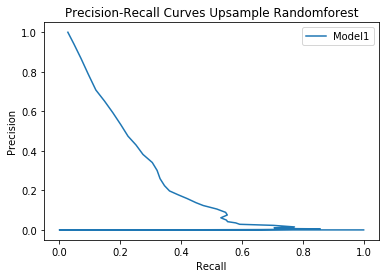

In [85]:
plt.plot(prec_n, rec_n, label = "Model1")
# plt.plot(prec2, rec2, label = "Model2")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves Upsample Randomforest")
plt.legend()
plt.savefig("./fig/precision_recall_curves_upsample_random_forest.png")
plt.show()

### original dataset precision recall

In [92]:
# # Splitting original data
split = StratifiedKFold(n_splits=4, random_state=42)
for train_index, test_index in split.split(df_og, label_og):
     X_train = df_og.iloc[train_index, :].values
     X_test = df_og.iloc[test_index, :].values
     y_train = label_og.iloc[train_index].values
     y_test = label_og.iloc[test_index].values

In [95]:
X_train_prepped = prep_pipeline.fit_transform(X_train)
X_test_prepped = prep_pipeline.fit_transform(X_test)

In [96]:
from sklearn import metrics
prep_and_predict.fit(X_train_prepped,y_train)
y_pred = prep_and_predict.predict_proba(X_test_prepped)[:, 1]
prec_n, rec_n, _ = metrics.precision_recall_curve(y_test, y_pred)

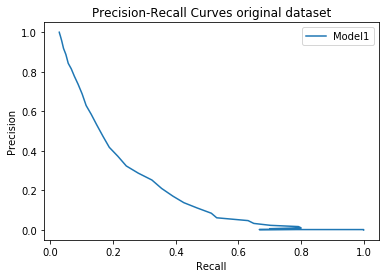

In [97]:
plt.plot(prec_n, rec_n, label = "Model1")
# plt.plot(prec2, rec2, label = "Model2")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves original dataset")
plt.legend()
plt.savefig("./fig/precision_recall_curves_original_dataset_random_forest.png")
plt.show()

# We see that downsampling behaves the best of the three. From this point forward, we will only use the downsampled dataset.

### Feature importances from a quick Random Forest

In [269]:
feature_label=df_downsampled.columns[0:,]
feature_col=df_filtered_time.columns.values
feature_col_mm=list(filter(lambda k: k.endswith('_max') or k.endswith('_min'), feature_col))
feature_col_mm.sort()
feature_col_mm
for i,k in zip(feature_col_mm[0::2], feature_col_mm[1::2]):
    col_name_new=i.split('_')[0]+"_range"
    df_filtered_time[col_name_new] = df_filtered_time[i]-df_filtered_time[k]

X_train = df_downsampled.values
imr = SimpleImputer(missing_values = np.nan, strategy = 'mean')
imr = imr.fit(X_train)
X_train = imr.transform(X_train)
y_train = label_downsampled.values
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)

from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=500, random_state=1, n_jobs=-1, verbose=1)
forest.fit(X_train_std,y_train)
importances = forest.feature_importances_
indices=np.argsort(importances)[::-1]
print("length of importances:",len(importances),"length of feature label",len(feature_label),"length of indices",len(indices))
for f in range(X_train.shape[1]):
    print ("%2d) %-*s %f" % (f+1,30, feature_label[indices[f]],importances[indices[f]]))
plt.figure(figsize=(25,10),dpi=1000)
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]),importances[indices],align='center')
plt.xticks(range(X_train.shape[1]),feature_label,rotation=90,fontsize='xx-small')
plt.xlim([-1,X_train_std.shape[1]])
# plt.tight_layout()
plt.savefig("./images/feature_importances.png")
plt.show()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.8s finished


length of importances: 314 length of feature label 314 length of indices 314
 1) Glascow coma scale verbal response_mean 0.026033
 2) Glascow coma scale motor response_max 0.025942
 3) Glascow coma scale motor response_mean 0.025358
 4) Glascow coma scale verbal response_max 0.023912
 5) Glascow coma scale verbal response_min 0.019920
 6) Glascow coma scale eye opening_mean 0.018213
 7) Glascow coma scale eye opening_min 0.016554
 8) MAIN_drug                      0.015365
 9) Systolic blood pressure_min    0.013688
10) White blood cell count_mean    0.013350
11) abnormal_lab_Urea Nitrogen     0.013255
12) White blood cell count_min     0.013228
13) Respiratory rate_mean          0.013013
14) Creatinine_mean                0.013007
15) White blood cell count_max     0.012680
16) Systolic blood pressure_mean   0.012566
17) Heart Rate_max                 0.012428
18) Mean blood pressure_min        0.012280
19) Glascow coma scale motor response_min 0.012002
20) Heart Rate_mean            

### parameter grid can be adjusted freely here

In [24]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
param_grid = [{
    'prep__range_remove__kw_args': [{'remove_range': False}, {"remove_range": True}],
    'prep__urine_remove__kw_args': [{"remove_urine": False}, {"remove_urine": True}],
    'prep__abnormal_sum__kw_args': [{"sum_abnormal_lab": False}, {"sum_abnormal_lab": True}],
    'prep__remove_abnormal_labs__kw_args': [{'remove_abnormal_lab': False}, {'remove_abnormal_lab': True}],
    'prep__remove_na_percent__percent_na': [.3, .35, .4, .45, .5]
}]
grid_search = GridSearchCV(prep_and_predict, param_grid, cv=skf, n_jobs=-1, verbose=1, scoring='f1')

### Tune hyperparameter with downsampled data to save time

In [54]:
grid_search.fit(df_downsampled.values, label_downsampled.values)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  1.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('prep', Pipeline(memory=None,
     steps=[('range_remove', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function range_remover at 0x1a244126a8>, inv_kw_args=None,
          inverse_func=None, kw_args={'remove_range': True},
          pass_y='deprecated', valid...stimators=50, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'prep__range_remove__kw_args': [{'remove_range': False}, {'remove_range': True}], 'prep__urine_remove__kw_args': [{'remove_urine': False}, {'remove_urine': True}], 'prep__abnormal_sum__kw_args': [{'sum_abnormal_lab': False}, {'sum_abnormal_lab': True}], 'prep__remove_abnormal_labs__kw_args': [{'remove_abnormal_lab': False}, {'remove_abnormal_lab': True}], 'prep__re

### After hyperparameter tuning, extract optimal model

In [58]:
f1_best_param_downsample = grid_search.best_params_
f1_best_param_downsample

{'prep__abnormal_sum__kw_args': {'sum_abnormal_lab': False},
 'prep__range_remove__kw_args': {'remove_range': True},
 'prep__remove_abnormal_labs__kw_args': {'remove_abnormal_lab': False},
 'prep__remove_na_percent__percent_na': 0.4,
 'prep__urine_remove__kw_args': {'remove_urine': False}}

In [56]:
grid_search.best_score_

0.791357099090014

In [53]:
grid_search.best_score_

0.791357099090014

### Feed best params into data prep pipline alone, no model

In [25]:
best = {'range_remove__kw_args': {'remove_range': True},
    'abnormal_sum__kw_args': {'sum_abnormal_lab': False},
 'remove_abnormal_labs__kw_args': {'remove_abnormal_lab': False},
 'remove_na_percent__percent_na': 0.4,
 'urine_remove__kw_args': {'remove_urine': False}}

In [26]:
prep_pipeline.set_params(**best)

Pipeline(memory=None,
     steps=[('range_remove', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function range_remover at 0x1a1eb24d08>, inv_kw_args=None,
          inverse_func=None, kw_args={'remove_range': True},
          pass_y='deprecated', validate=False)), ('urine_remove', FunctionTrans...egy='median', verbose=0)), ('std_scalar', StandardScaler(copy=True, with_mean=True, with_std=True))])

In [242]:
# Renaming upsampled data
X_train = df_upsampled_train.values
X_test = df_upsampled_test.values
y_train = label_upsampled_train.values
y_test = label_upsampled_test.values


# Only use downsample

In [238]:
# Splitting downsampled data
split = StratifiedKFold(n_splits=4, random_state=42)
for train_index, test_index in split.split(df_downsampled, label_downsampled):
    X_train = df_downsampled.iloc[train_index, :].values
    X_test = df_downsampled.iloc[test_index, :].values
    y_train = label_downsampled.iloc[train_index].values
    y_test = label_downsampled.iloc[test_index].values
X_test.shape

(2375, 314)

In [236]:
# # Splitting original data
# split = StratifiedKFold(n_splits=4, random_state=42)
# for train_index, test_index in split.split(df_og, label_og):
#     X_train = df_og.iloc[train_index, :].values
#     X_test = df_og.iloc[test_index, :].values
#     y_train = label_og.iloc[train_index].values
#     y_test = label_og.iloc[test_index].values

### Prep downsampled data through the pipeline with optimal parameters

In [243]:
X_train_prepped = prep_pipeline.fit_transform(X_train)
X_test_prepped = prep_pipeline.transform(X_test)

In [31]:
X_train_prepped.shape

(7127, 294)

# Train various models on prepped data

### Logistic Regression

In [32]:
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
param_grid = {
     'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear']
}
logistic_grid = GridSearchCV(logistic, param_grid, cv=3, n_jobs=-1, verbose=1, scoring='f1')
logistic_grid.fit(X_train_prepped, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.4min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([1.00000e-04, 2.63665e-04, 6.95193e-04, 1.83298e-03, 4.83293e-03,
       1.27427e-02, 3.35982e-02, 8.85867e-02, 2.33572e-01, 6.15848e-01,
       1.62378e+00, 4.28133e+00, 1.12884e+01, 2.97635e+01, 7.84760e+01,
       2.06914e+02, 5.45559e+02, 1.43845e+03, 3.79269e+03, 1.00000e+04]), 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [66]:
logistic_grid.best_params_

{'C': 0.23357214690901212, 'penalty': 'l1', 'solver': 'liblinear'}

In [67]:
logistic_grid.best_score_

0.7720683576857096

In [69]:
from sklearn.externals import joblib
filename = './models/logistic_best.pkl'
logit_best = logistic_grid.best_estimator_
joblib.dump(logit_best, filename)

['./models/logistic_best.pkl']

### MLP

In [82]:
from sklearn import neural_network
mlp = neural_network.MLPClassifier(random_state=1)

param_grid = {'solver': ['adam'], 
              'max_iter': [200, 500], 
              'alpha': [.001, .01, .1, 1],
              'activation': ['relu', 'logistic'],
              'hidden_layer_sizes': [(50,), (100,), (50,50), (50,50,50)]
              }
gs_mlp =GridSearchCV(mlp, param_grid, cv = 4, scoring='f1', n_jobs = -1, verbose=1)
gs_mlp = gs_mlp.fit(X_train_prepped, y_train)
print(gs_mlp.best_score_)
print(gs_mlp.best_params_)

Fitting 4 folds for each of 64 candidates, totalling 256 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed: 12.4min finished


0.7854656651987872
{'activation': 'relu', 'alpha': 1, 'hidden_layer_sizes': (100,), 'max_iter': 200, 'solver': 'adam'}


In [83]:
from sklearn.externals import joblib
filename = './models/mlp_best.pkl'
mlp_best = gs_mlp.best_estimator_
joblib.dump(mlp_best, filename)

['./models/mlp_best.pkl']

### SVM

In [40]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
pipe_svc=make_pipeline(SVC(max_iter=50000, verbose=2, class_weight='balanced',random_state=1))
c_range = [0.001,0.01,0.1,1,10,100]
gamma_range = [0.0001,0.001,0.01,0.1,1,10]
param_grid=[{'svc__C':c_range,'svc__kernel':['linear']},{'svc__C':c_range,
                        'svc__gamma':gamma_range,'svc__kernel':['rbf']}]
gs_svm = GridSearchCV(estimator=pipe_svc,param_grid=param_grid,scoring='f1',
                 cv=5,n_jobs=-1)
gs_svm=gs_svm.fit(X_train_prepped,y_train)
print(gs_svm.best_score_)
print(gs_svm.best_params_)

[LibSVM]0.7857048180912888
{'svc__C': 10, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [42]:
from sklearn.externals import joblib
filename = '/Users/ergangwang/Downloads/DSAH_Final/svm_optimized.sav'
svm_best = gs_svm.best_estimator_
joblib.dump(svm_best, filename)

['/Users/ergangwang/Downloads/DSAH_Final/svm_optimized.sav']

### Random Forest

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
pipe_rdf = make_pipeline(RandomForestClassifier(verbose=2,random_state=1,class_weight='balanced'))
#number of treew in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop=2000, num=10)]
#number of features to consider at every split
max_features = ['auto','log2',None]
#maximum number of levels in tree
max_depth=[int(x) for x in np.linspace(10,110,num=11)]
max_depth.append(None)
#minimum number of samples required to split a node
min_samples_split=[2,5,10]
#minimum number of samples required at each leaf node
min_samples_leaf=[1,2,4]
#method of selecting samples for training each tree
bootstrap=[True,False]
#function that measure quality of a split
criterion=['gini','entropy']

param_grid = {'randomforestclassifier__n_estimators': n_estimators, 
              'randomforestclassifier__max_features':max_features,
             'randomforestclassifier__max_depth':max_depth,
              'randomforestclassifier__min_samples_split':min_samples_split,
              'randomforestclassifier__min_samples_leaf':min_samples_leaf,
             'randomforestclassifier__bootstrap': bootstrap,
             "randomforestclassifier__criterion": criterion}

# param_grid = {"randomforestclassifier__max_depth": [3, None],
#               "randomforestclassifier__max_features": [1, 3, 10],
#               "randomforestclassifier__min_samples_split": [2, 3, 10],
#               "randomforestclassifier__bootstrap": [True, False],
#               "randomforestclassifier__criterion": criterion}
gs_rdf = RandomizedSearchCV(estimator = pipe_rdf, param_distributions = param_grid, n_iter = 100, cv = 5, verbose=2, random_state=1,scoring='f1', n_jobs = -1)
#gs_rdf = GridSearchCV(pipe_rdf, param_grid=param_grid, scoring='f1',cv=5, n_jobs=-1)
gs_rdf=gs_rdf.fit(X_train_prepped, y_train)
print(gs_rdf.best_score_)
print(gs_rdf.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 37.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 143.6min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 260.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 320.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


building tree 1 of 2000
building tree 2 of 2000
building tree 3 of 2000
building tree 4 of 2000
building tree 5 of 2000
building tree 6 of 2000
building tree 7 of 2000
building tree 8 of 2000
building tree 9 of 2000
building tree 10 of 2000
building tree 11 of 2000
building tree 12 of 2000
building tree 13 of 2000
building tree 14 of 2000
building tree 15 of 2000
building tree 16 of 2000
building tree 17 of 2000
building tree 18 of 2000
building tree 19 of 2000
building tree 20 of 2000
building tree 21 of 2000
building tree 22 of 2000
building tree 23 of 2000
building tree 24 of 2000
building tree 25 of 2000
building tree 26 of 2000
building tree 27 of 2000
building tree 28 of 2000
building tree 29 of 2000
building tree 30 of 2000
building tree 31 of 2000
building tree 32 of 2000
building tree 33 of 2000
building tree 34 of 2000
building tree 35 of 2000
building tree 36 of 2000
building tree 37 of 2000
building tree 38 of 2000
building tree 39 of 2000
building tree 40 of 2000
building 

[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:  7.4min finished


In [57]:
pipe_rdf_1 = make_pipeline(RandomForestClassifier(verbose=2,random_state=1,class_weight='balanced'))
#number of treew in random forest

param_grid_1 = {'randomforestclassifier__n_estimators': [100,200], 
              'randomforestclassifier__max_features':[None],
             'randomforestclassifier__max_depth':[1,5,8],
              'randomforestclassifier__min_samples_split':[5],
              'randomforestclassifier__min_samples_leaf':[4],
             'randomforestclassifier__bootstrap': [True],
             "randomforestclassifier__criterion": ['entropy']}

# param_grid = {"randomforestclassifier__max_depth": [3, None],
#               "randomforestclassifier__max_features": [1, 3, 10],
#               "randomforestclassifier__min_samples_split": [2, 3, 10],
#               "randomforestclassifier__bootstrap": [True, False],
#               "randomforestclassifier__criterion": criterion}
gs_rdf_1 = GridSearchCV(pipe_rdf_1, param_grid = param_grid_1, cv = 5, verbose=2,scoring='f1', n_jobs = -1)
#gs_rdf = GridSearchCV(pipe_rdf, param_grid=param_grid, scoring='f1',cv=5, n_jobs=-1)
gs_rdf_1=gs_rdf_1.fit(X_train_prepped, y_train)
print(gs_rdf_1.best_score_)
print(gs_rdf_1.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   16.8s finished


In [47]:
pipe_rdf = make_pipeline(RandomForestClassifier(verbose=2,random_state=1,class_weight='balanced'))
pipe_rdf.get_params().keys()

dict_keys(['memory', 'steps', 'randomforestclassifier', 'randomforestclassifier__bootstrap', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__max_leaf_nodes', 'randomforestclassifier__min_impurity_decrease', 'randomforestclassifier__min_impurity_split', 'randomforestclassifier__min_samples_leaf', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__min_weight_fraction_leaf', 'randomforestclassifier__n_estimators', 'randomforestclassifier__n_jobs', 'randomforestclassifier__oob_score', 'randomforestclassifier__random_state', 'randomforestclassifier__verbose', 'randomforestclassifier__warm_start'])

In [51]:
filename = '/Users/ergangwang/Downloads/DSAH_Final/rdf_optimized.pkl'
rdf_best = gs_rdf.best_estimator_
joblib.dump(rdf_best, filename)

['/Users/ergangwang/Downloads/DSAH_Final/rdf_optimized.pkl']

### Adaboost

In [80]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

param_grid = {
              "n_estimators": [50, 100, 150, 200, 250, 300],
              "learning_rate": [.2, .4, 0.5, 1, 2],
             }

ABC = AdaBoostClassifier(random_state=1)

# run grid search
gs_abc = GridSearchCV(ABC, param_grid, scoring='f1',cv=4, n_jobs=-1, verbose=1)
gs_abc=gs_abc.fit(X_train_prepped, y_train)
print(gs_abc.best_score_)
print(gs_abc.best_params_)

TypeError: __init__() got an unexpected keyword argument 'random_state'

In [78]:
from sklearn.metrics import f1_score
y_pred = gs_abc.best_estimator_.predict(X_test_prepped)
f1_score(y_test, y_pred)

0.7786470317533364

In [79]:
filename = './models/ada_best.pkl'
abc_best = gs_abc.best_estimator_
joblib.dump(abc_best, filename)

['./models/ada_best.pkl']

### Gradient Boost Chris

### Param screening round one

In [99]:
from sklearn.ensemble import GradientBoostingClassifier
param_grid = { "n_estimators": range(150, 250, 10),
              "learning_rate": [.15],
              'min_samples_split': [2, 5, 10, 20, 50],
              'min_samples_leaf': [1, 5, 10, 20],
              'max_depth': [3, 5, 8]
             }
param_grid = {  "n_estimators": range(200, 250, 10),
              "learning_rate": [.15],
              'min_samples_split': [2, 5, 10, 20, 50],
             }
GBC = GradientBoostingClassifier(random_state=1)

# run grid search
gs_gbc = GridSearchCV(GBC, param_grid, scoring='f1',cv=4, n_jobs=-1, verbose=1)
gs_gbc=gs_gbc.fit(X_train_prepped, y_train)
print(gs_gbc.best_score_)
print(gs_gbc.best_params_)
from sklearn.metrics import f1_score
y_pred = gs_gbc.best_estimator_.predict(X_test_prepped)
f1_score(y_test, y_pred)


Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.4min finished


0.8065649792363008
{'learning_rate': 0.15, 'min_samples_split': 10, 'n_estimators': 200}


0.8003613369467028

### Param screening round two

In [101]:
param_grid = { "n_estimators": [200],
              "learning_rate": [.15],
              'min_samples_split': [10],
              'min_samples_leaf': [1, 5, 10, 20],
              'max_depth': [3, 5, 8]
             }
GBC = GradientBoostingClassifier(random_state=1)

# run grid search
gs_gbc = GridSearchCV(GBC, param_grid, scoring='f1',cv=4, n_jobs=-1, verbose=1)
gs_gbc=gs_gbc.fit(X_train_prepped, y_train)
print(gs_gbc.best_score_)
print(gs_gbc.best_params_)
from sklearn.metrics import f1_score
y_pred = gs_gbc.best_estimator_.predict(X_test_prepped)
f1_score(y_test, y_pred)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 10.1min finished


0.8099220962298026
{'learning_rate': 0.15, 'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}


0.8021295474711624

In [180]:
from sklearn.ensemble import GradientBoostingClassifier
param_grid = { "n_estimators": [200],
              "learning_rate": [.15],
              'min_samples_split': [10],
              'min_samples_leaf': [5],
              'max_depth': [8]
             }
GBC = GradientBoostingClassifier(random_state=1)

# run grid search
gs_gbc = GridSearchCV(GBC, param_grid, scoring='f1',cv=4, n_jobs=-1, verbose=1)
gs_gbc=gs_gbc.fit(X_train_prepped, y_train)
print(gs_gbc.best_score_)
print(gs_gbc.best_params_)
from sklearn.metrics import f1_score
y_pred = gs_gbc.best_estimator_.predict(X_test_prepped)
f1_score(y_test, y_pred)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  1.1min finished


0.8099220962298026
{'learning_rate': 0.15, 'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}


0.8021295474711624

### Gradient Boosting with Early Stopping

In [181]:
from sklearn.metrics import mean_squared_error
gbc_best = gs_gbc.best_estimator_
errors = [mean_squared_error(y_test, y_pred)
          for y_pred in gbc_best.staged_predict(X_test_prepped)]
bst_n_estimators = np.argmin(errors)
gbrt_earlystop = GradientBoostingClassifier(learning_rate=.15, 
                                            n_estimators=bst_n_estimators,
                                           min_samples_split=10,
                                           max_depth=8,
                                           min_samples_leaf=5,
                                           random_state=1)
gbrt_earlystop.fit(X_train_prepped, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.15, loss='deviance', max_depth=8,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=5, min_samples_split=10,
              min_weight_fraction_leaf=0.0, n_estimators=187,
              n_iter_no_change=None, presort='auto', random_state=1,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [110]:
y_pred = gbrt_earlystop.predict(X_test_prepped)
f1_score(y_test, y_pred)

0.8026607538802659

In [125]:
filename = './models/gradientboost_best_early_stopping.pkl'
joblib.dump(gbrt_earlystop, filename)

['./models/gradientboost_best_early_stopping.pkl']

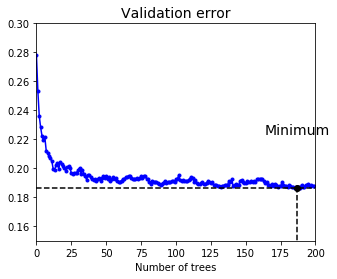

In [182]:
min_error = np.min(errors)
plt.figure(figsize=(11, 4))
plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 200], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 200, .15, .3])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)
plt.savefig('./images/gbc_early_stop.png', dpi=300)

### XGBoost Chris

In [32]:
import xgboost

### Round 1 tuning

In [58]:
param_grid = { 'min_child_weight':[4],
              'max_depth': [8],
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
             }
xgb = xgboost.XGBClassifier(random_state=1)

# run grid search
gs_xgb = GridSearchCV(xgb, param_grid, scoring='f1',cv=4, n_jobs=-1, verbose=1)
gs_xgb.fit(X_train_prepped, y_train)

Fitting 4 folds for each of 16 candidates, totalling 64 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   56.8s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:  1.6min finished


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'min_child_weight': [4], 'max_depth': [8], 'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [59]:
gs_xgb.best_score_, gs_xgb.best_params_

(0.8119225869792578,
 {'colsample_bytree': 0.7,
  'max_depth': 8,
  'min_child_weight': 4,
  'subsample': 0.7})

In [60]:
from sklearn.metrics import f1_score
y_pred = gs_xgb.best_estimator_.predict(X_test_prepped)
f1_score(y_test, y_pred)

0.802873821284239

### Round two 

In [69]:
param_grid = { 'min_child_weight':[4],
              'max_depth': [8],
         'subsample':[.7],
         'colsample_bytree':[.7],
              'reg_alpha':[.1],
              'learning_rate': [.08, .1, .12],
              'n_estimators': range(80, 200, 20)
             }
xgb = xgboost.XGBClassifier(random_state=1)

# run grid search
gs_xgb = GridSearchCV(xgb, param_grid, scoring='f1',cv=4, n_jobs=-1, verbose=1)
gs_xgb.fit(X_train_prepped, y_train)
gs_xgb.best_score_, gs_xgb.best_params_

Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  2.4min finished


(0.8147282506462465,
 {'colsample_bytree': 0.7,
  'learning_rate': 0.1,
  'max_depth': 8,
  'min_child_weight': 4,
  'n_estimators': 100,
  'reg_alpha': 0.1,
  'subsample': 0.7})

In [70]:
from sklearn.metrics import f1_score
y_pred = gs_xgb.best_estimator_.predict(X_test_prepped)
f1_score(y_test, y_pred)

0.8103989242492157

In [72]:
from sklearn.externals import joblib
filename = './models/xgboost_best.pkl'
joblib.dump(gs_xgb.best_estimator_, filename)

['./models/xgboost_best.pkl']

# Ensemble

In [128]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='label')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        y : array-like, shape = [n_samples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_samples, n_classes]
            Weighted average probability for each class per sample.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out


### Load all saved models

In [192]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
logistic_best = joblib.load('./models/logistic_best.pkl')
mlp_best = joblib.load('./models/mlp_best.pkl')
svm_best = joblib.load('./models/svm_optimized.sav')
ada_best = joblib.load('./models/ada_best.pkl')
gb_best = joblib.load('./models/gradientboost_best.pkl')
gbstop_best = joblib.load('./models/gradientboost_best_early_stopping.pkl')
xgb_best = joblib.load('./models/xgboost_best.pkl')
rdf_best = joblib.load('./models/rdf_optimized.sav', )


In [193]:
svm_best.set_params(svc__verbose=0, svc__probability=True)
rdf_best.set_params(randomforestclassifier__verbose=0, randomforestclassifier__n_jobs=-1)
logistic_best.set_params(n_jobs=-1)
xgb_best.set_params(n_jobs=-1)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=4, missing=nan, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=1, reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.7)

In [194]:
w = [.5, 1.5, 1, .5, 2.5, 3, 1]
mv_clf_eq = MajorityVoteClassifier(classifiers=[logistic_best, mlp_best, rdf_best, svm_best, ada_best, gbstop_best, xgb_best], weights=None)
mv_clf_wt = MajorityVoteClassifier(classifiers=[logistic_best, mlp_best, rdf_best, svm_best, ada_best, gbstop_best, xgb_best], weights=w)
all_clf= [logistic_best, mlp_best,rdf_best, svm_best, ada_best, gbstop_best, xgb_best, mv_clf_eq, mv_clf_wt]
clf_labels = ['Logistic regression','MLP','Random Forest', 'SVM','AdaBoost', 'GradientBoost','XGBoost','Majority voting, equally weighted', 'Majority voting, weighted']

In [201]:
f1_dict = {}
auc_dict = {}

In [202]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

print('4-fold cross validation:\n')
for clf, label in zip(all_clf, clf_labels):
    f1_scores = cross_val_score(estimator=clf,
                             X=X_train_prepped,
                             y=y_train,
                             cv=4,
                             scoring='f1')
    auc_scores = cross_val_score(estimator=clf,
                             X=X_train_prepped,
                             y=y_train,
                             cv=4,
                             scoring='roc_auc')
    f1_dict[label] = f1_scores
    auc_dict[label] = auc_scores
    print("F1 : %0.5f (+/- %0.5f) ROC AUC: %0.5f (+/- %0.5f) [%s]"
          % (f1_scores.mean(), f1_scores.std(), auc_scores.mean(), auc_scores.std(), label))

4-fold cross validation:

F1 : 0.77512 (+/- 0.01067) ROC AUC: 0.86774 (+/- 0.00748) [Logistic regression]
F1 : 0.78546 (+/- 0.00772) ROC AUC: 0.86791 (+/- 0.00537) [MLP]
F1 : 0.78252 (+/- 0.00942) ROC AUC: 0.87427 (+/- 0.00606) [Random Forest]
F1 : 0.79955 (+/- 0.00901) ROC AUC: 0.88836 (+/- 0.00657) [SVM]
F1 : 0.79000 (+/- 0.00448) ROC AUC: 0.88341 (+/- 0.00300) [AdaBoost]
F1 : 0.79000 (+/- 0.00448) ROC AUC: 0.88341 (+/- 0.00300) [GradiengBoost]
F1 : 0.80801 (+/- 0.00610) ROC AUC: 0.89407 (+/- 0.00521) [XGBoost]
F1 : 0.81473 (+/- 0.00766) ROC AUC: 0.89572 (+/- 0.00476) [Majority voting, equally weighted]


In [254]:
f1_mean = []
f1_std = []
for key,value in f1_dict.items():
    f1_mean.append(np.mean(value))
    f1_std.append(np.std(value))
auc_mean = []
auc_std = []
for key,value in auc_dict.items():
    auc_mean.append(np.mean(value))
    auc_std.append(np.std(value))

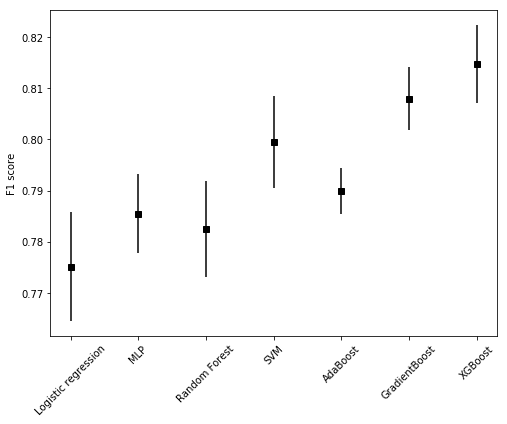

In [264]:
plt.figure(figsize=(8,6))
plt.errorbar(range(len(f1_dict)), f1_mean, yerr=f1_std, fmt='ks')
plt.xticks(range(len(f1_dict)), list(f1_dict.keys()), rotation=45)
plt.ylabel('F1 score')
plt.savefig('./images/f1_errorbar', dpi=300, bbox_inches='tight')
plt.show()

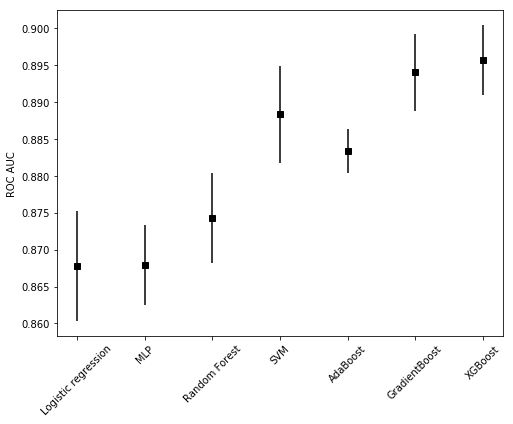

In [265]:
plt.figure(figsize=(8,6))
plt.errorbar(range(len(auc_dict)), auc_mean , yerr=auc_std, fmt='ks')
plt.xticks(range(len(auc_dict)), list(auc_dict.keys()), rotation=45)
plt.ylabel('ROC AUC')
plt.savefig('./images/auc_errorbar', dpi=300, bbox_inches='tight')
plt.show()

In [210]:
auc_dict = {'Logistic regression': np.array([0.85849914, 0.87509979, 0.86226335, 0.87509041]),
 'MLP': np.array([0.86514932, 0.87416127, 0.86056386, 0.87175087]),
 'Random Forest': np.array([0.86730044, 0.8800526 , 0.86920038, 0.88052396]),
 'SVM': np.array([0.88034216, 0.8883717 , 0.88618385, 0.89853293]),
 'AdaBoost': np.array([0.87936816, 0.88767318, 0.882403  , 0.88418088]),
 'GradientBoost': np.array([0.88710968, 0.89273588, 0.89477737, 0.90166256]),
 'XGBoost': np.array([0.8886388 , 0.8959607 , 0.89621131, 0.90206088])}

Logistic regression
MLP
Random Forest
SVM
AdaBoost
GradiengBoost
XGBoost
Majority voting, equally weighted
Majority voting, weighted


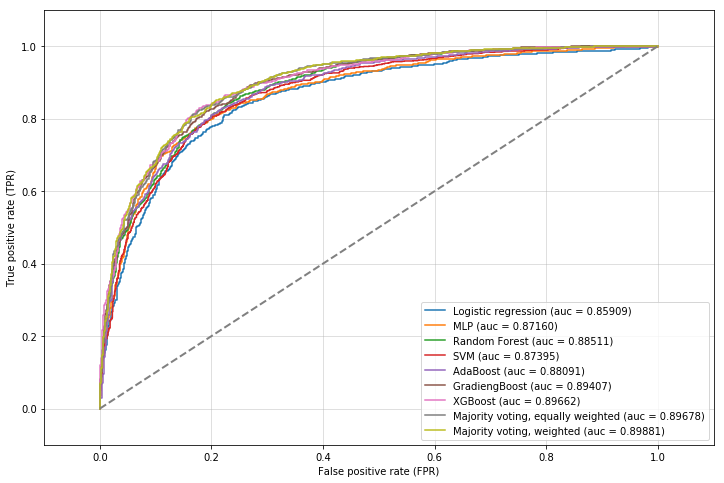

In [165]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fig = plt.figure(figsize=(12, 8))

plt.figure(num=1, figsize=(12, 8), dpi=300)
           # colors = ['black', 'orange', 'blue', 'green']
# linestyles = [':', '--', '-.', '-']
for clf, label \
        in zip(all_clf,
               clf_labels):
    print(label)
    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train_prepped, y_train).predict_proba(X_test_prepped)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
#              color=clr,
#              linestyle=ls,
             label='%s (auc = %0.5f)' % (label, roc_auc))


plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')


plt.savefig('./images/ROC_all.png', dpi=300)
plt.show()

Logistic regression
MLP
Random Forest
SVM
AdaBoost
GradiengBoost
XGBoost
Majority voting, equally weighted
Majority voting, weighted


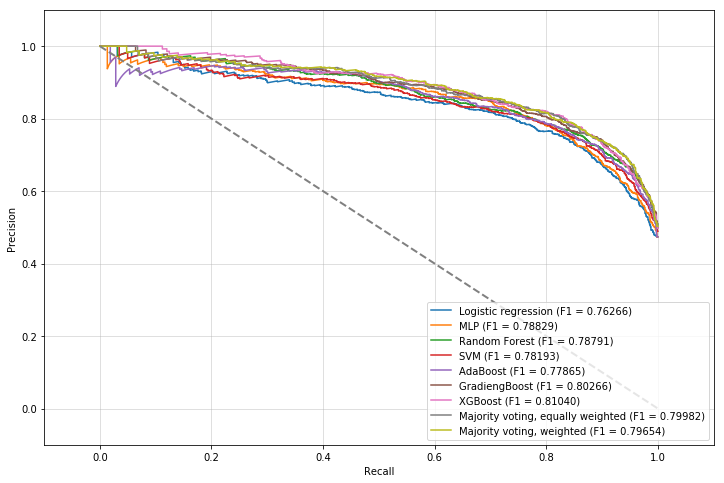

In [171]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
fig = plt.figure(figsize=(12, 8))

plt.figure(num=1, figsize=(12, 8), dpi=300)
           # colors = ['black', 'orange', 'blue', 'green']
# linestyles = [':', '--', '-.', '-']
for clf, label \
        in zip(all_clf,
               clf_labels):
    print(label)
    # assuming the label of the positive class is 1
    y_pred = clf.predict_proba(X_test_prepped)[:, 1]
    prec_n, rec_n, _ = precision_recall_curve(y_test, y_pred)
    y_pred_binary = clf.predict(X_test_prepped)
    f1 = f1_score(y_test, y_pred_binary)
    
    plt.plot(rec_n, prec_n,
#              color=clr,
#              linestyle=ls,
             label='%s (F1 = %0.5f)' % (label, f1))


plt.legend(loc='lower right')
plt.plot([0, 1], [1, 0],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('Recall')
plt.ylabel('Precision')


plt.savefig('./images/precision_recall_all.png', dpi=300)
plt.show()

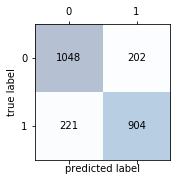

In [174]:
from sklearn.metrics import confusion_matrix
y_pred=xgb_best.predict(X_test_prepped)
confmat=confusion_matrix(y_true=y_test,y_pred=y_pred)
fig,ax=plt.subplots(figsize=(3,2.5))
ax.matshow(confmat, cmap=plt.cm.Blues,alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j,y=i,s=confmat[i,j],va='center',ha='center')
plt.xlabel('predicted label')
plt.ylabel("true label")
plt.savefig('./images/confusion_matrix.png', dpi=300)
plt.show()